## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_m, EfficientNet_V2_M_Weights
import numpy as np

## Data Loaders

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir =img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
class CustomDataset_Test(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir =img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        # label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)

        return image


## Helper Functions

In [4]:

def visualise(dataset, samples):
    for index in range(samples):
      image, label = dataset[index]

      print(f"Image Size: {image.size()}")

      to_pil = transforms.ToPILImage()
      image_np = to_pil(image)

      plt.figure(figsize=[10, 15])
      plt.imshow(image_np)
      plt.title(f"Label: {label}")
      plt.axis('off')
      plt.show()


In [5]:

def visualise_without_label(dataset, samples):
    for index in range(samples):
      image = dataset[index]

      print(f"Image Size: {image.size()}")

      to_pil = transforms.ToPILImage()
      image_np = to_pil(image)

      plt.figure(figsize=[10, 15])
      plt.imshow(image_np)
      plt.axis('off')
      plt.show()


In [6]:
class FocusedCrop(torch.nn.Module):

    def __init__(self, crop_percentage):
        super(FocusedCrop, self).__init__()
        self.crop_percentage = crop_percentage

    def forward(self, img):

        width, height = img.size
        left = width * (1 - self.crop_percentage) / 2
        top = height * (1 - self.crop_percentage) / 2
        right = width * (1 + self.crop_percentage) / 2
        bottom = height * (1 + self.crop_percentage) / 2
        # Built in img crop
        return img.crop((left, top, right, bottom))

In [7]:
def process_image(path, transform):
    with Image.open(path) as img:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(img)
        axs[0].set_title('Without Crop')

        #Ensures we are always cropping every image
        cropped_img = transform(img)

        axs[1].imshow(cropped_img)
        axs[1].set_title('With Crop')

        plt.tight_layout()
        plt.show()

## Data Augmentation

In [9]:


# finding avg size
def avg_img_size(folder_path):
    sizes = []
    # print(os.listdir(folder_path))
    for filename in os.listdir(folder_path):

        if filename.endswith(('jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                sizes.append(img.size)

    sizes = np.array(sizes)
    avg_size = sizes.mean(axis=0)
    return avg_size


avg = avg_img_size("/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/test")
print(f"Average image size (test): {avg}")

avg1 =  avg_img_size("/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/train")
print(f"Average image size (train): {avg1}")





Average image size (test): [672.68848039 465.21397059]
Average image size (train): [667.46674728 461.86674728]


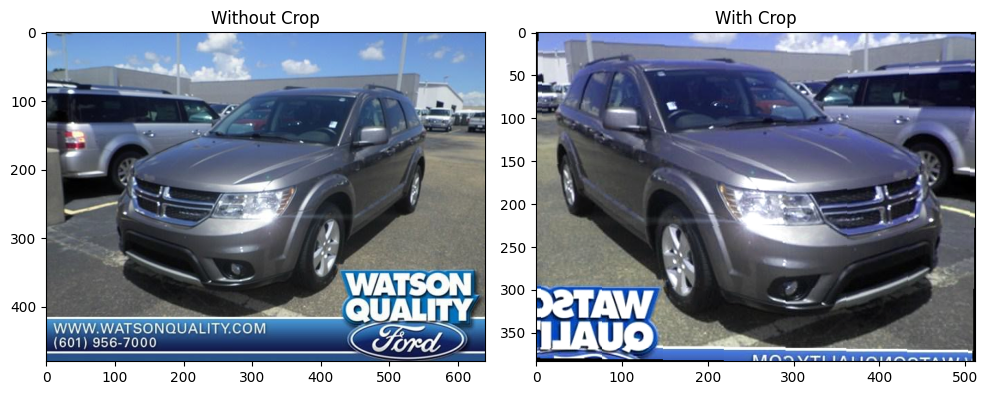

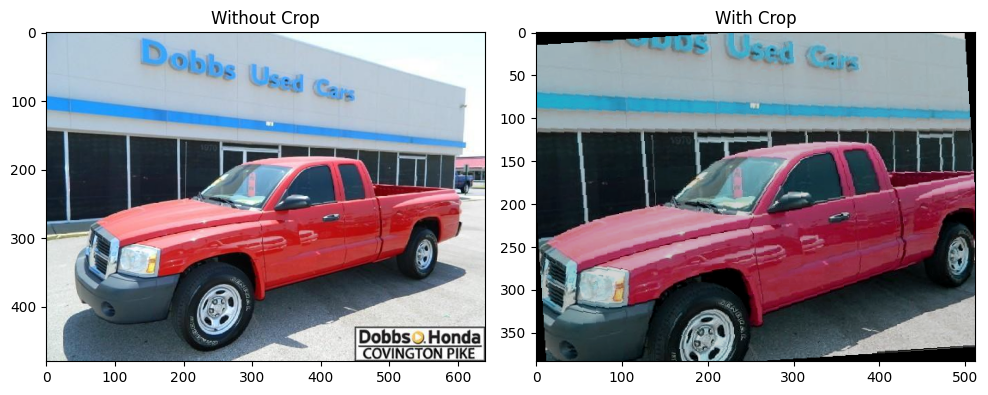

In [30]:
crop_percentage = 0.8
t = transforms.Compose([
    FocusedCrop(crop_percentage),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAutocontrast(0.1),
    #transforms.Resize([ 256, 512]),
    #transforms.ToTensor()
    # transforms.ToTensor()
    # transforms.Grayscale(num_output_channels=1)
])

process_image("/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/train/65.jpg", t)
process_image("/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/train/24.jpg", t)

In [31]:
crop_percentage = 0.8
transform = transforms.Compose([
    t,
    transforms.Resize([ 256, 512]),
    transforms.ToTensor()
    # transforms.Grayscale(num_output_channels=1)
])




## Creating Datasets

In [32]:
train_dataset = CustomDataset(csv_file='/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/train.csv', img_dir='/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data', transform=transform)
#test_dataset = CustomDataset_Test(csv_file='/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/test.csv', img_dir='/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data', transform=transform)

In [41]:
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

print(len(train_subset))
print(len(val_subset))
print(len(test_subset))
print()
print(len(train_dataset))

3308
413
414

4135


### Data Exploration

In [16]:
# takes __ mins to execute
class_list = {} # {label : number of samples}
for image, label in train_dataset:

  if label in class_list:
    class_list[label] += 1

  else:
    class_list[label] = 1

In [19]:
sorted_keys = sorted(class_list.keys())
for key in sorted_keys:
  print("For label {}, there are {} samples".format(key, class_list[key]))

For label 0, there are 38 samples
For label 1, there are 37 samples
For label 2, there are 41 samples
For label 3, there are 43 samples
For label 4, there are 43 samples
For label 5, there are 44 samples
For label 6, there are 41 samples
For label 7, there are 43 samples
For label 8, there are 41 samples
For label 9, there are 46 samples
For label 10, there are 42 samples
For label 11, there are 43 samples
For label 12, there are 40 samples
For label 13, there are 45 samples
For label 14, there are 40 samples
For label 15, there are 34 samples
For label 16, there are 36 samples
For label 17, there are 41 samples
For label 18, there are 43 samples
For label 19, there are 42 samples
For label 20, there are 44 samples
For label 21, there are 42 samples
For label 22, there are 42 samples
For label 23, there are 45 samples
For label 24, there are 41 samples
For label 25, there are 41 samples
For label 26, there are 39 samples
For label 27, there are 41 samples
For label 28, there are 37 sam

In [51]:
min_value_key = min(class_list, key=class_list.get)
lowest_value = class_list[min_value_key]

max_value_key = max(class_list, key=class_list.get)
highest_value = class_list[max_value_key]


print(f"Lowest number of samples: {lowest_value} for label : {min_value_key}")
print(f"Highest number of samples: {highest_value} for label : {max_value_key}")

Lowest number of samples: 28 for label : 88
Highest number of samples: 49 for label : 68


In [ ]:
visualise_without_label(test_dataset, 10)

Image Size: torch.Size([3, 256, 512])


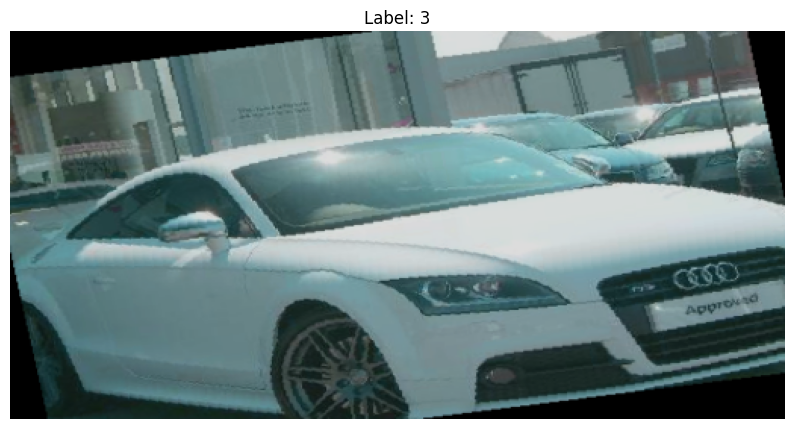

Image Size: torch.Size([3, 256, 512])


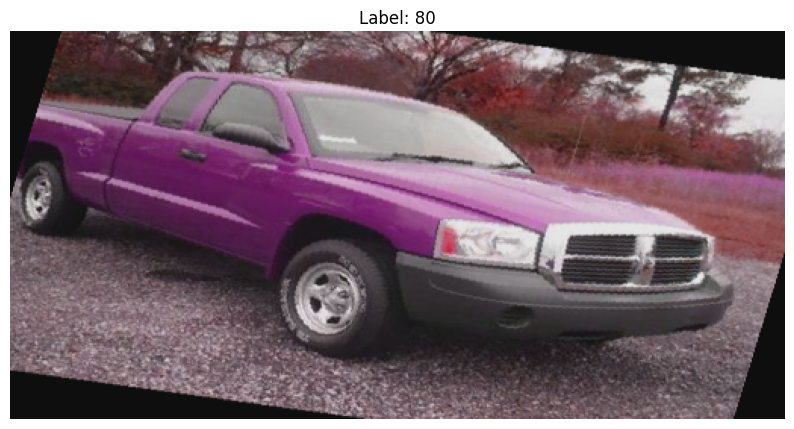

Image Size: torch.Size([3, 256, 512])


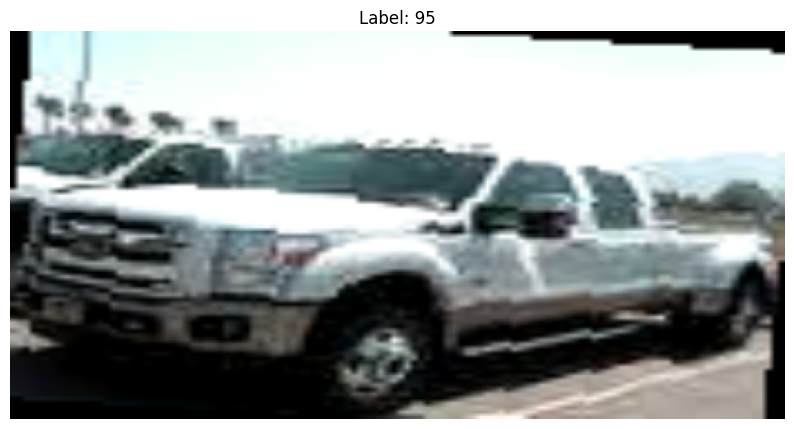

Image Size: torch.Size([3, 256, 512])


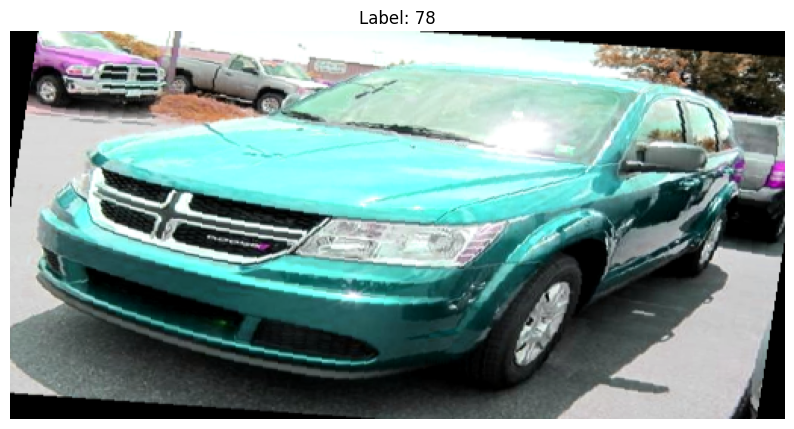

Image Size: torch.Size([3, 256, 512])


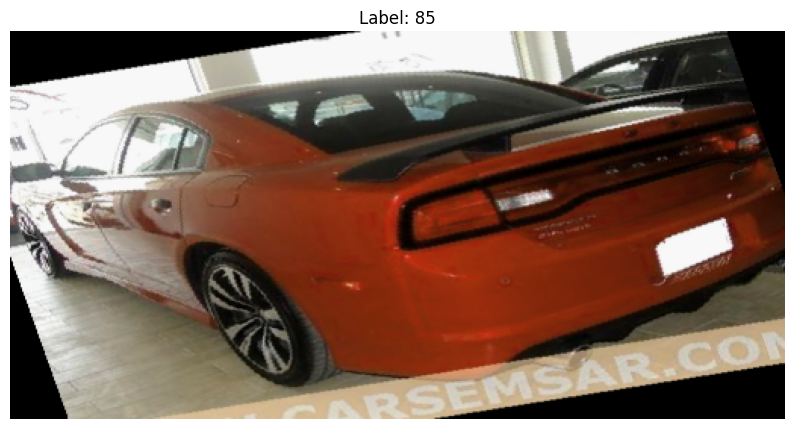

Image Size: torch.Size([3, 256, 512])


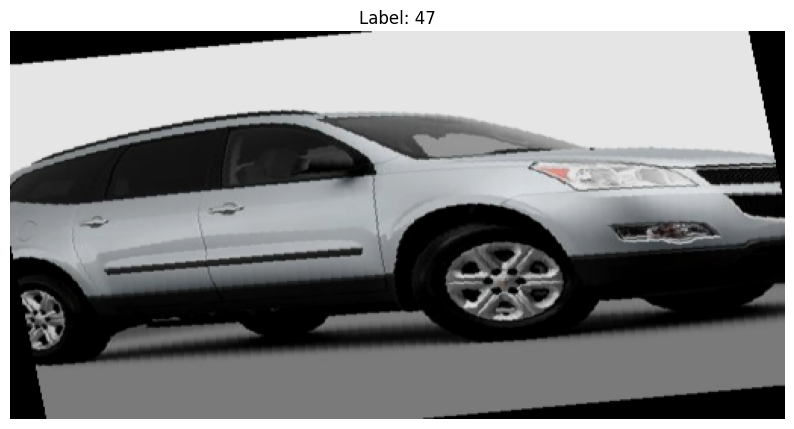

Image Size: torch.Size([3, 256, 512])


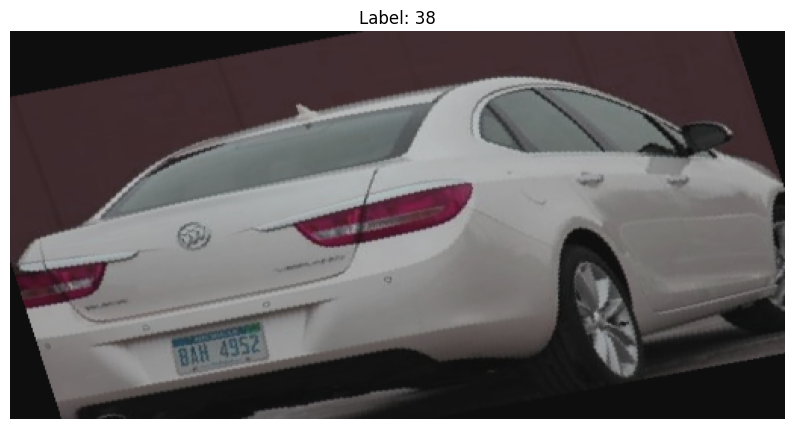

Image Size: torch.Size([3, 256, 512])


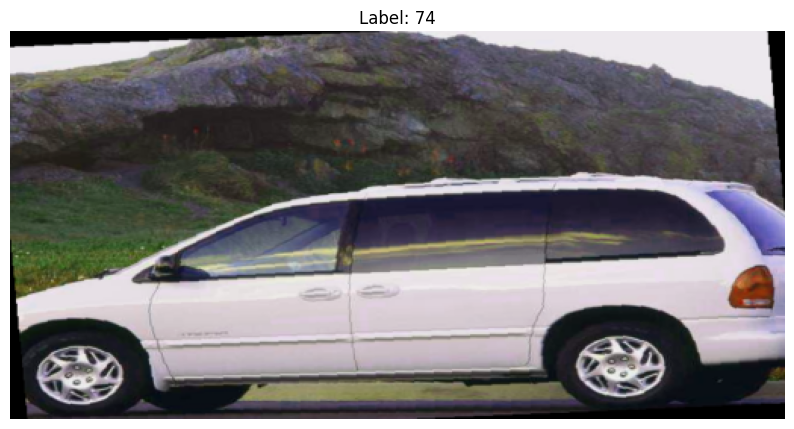

Image Size: torch.Size([3, 256, 512])


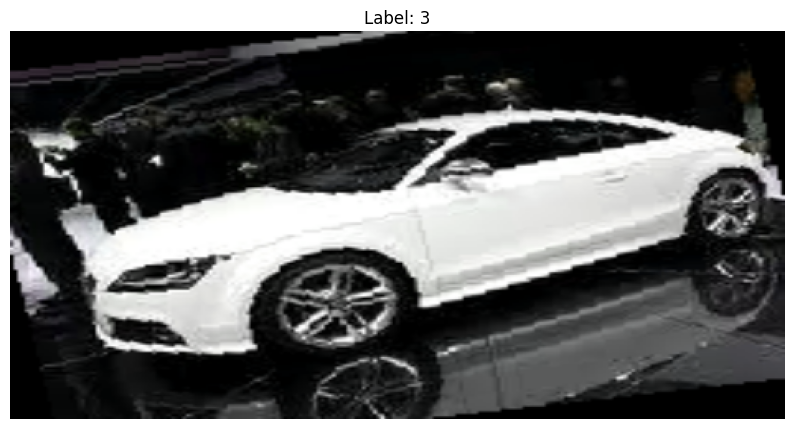

Image Size: torch.Size([3, 256, 512])


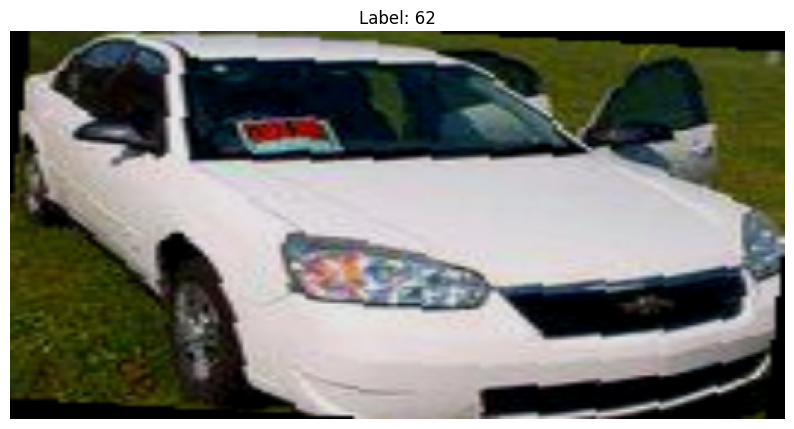

In [38]:
visualise(train_dataset, 10)

In [39]:
image_sizes = []


for image_tensor, label in train_dataset:
    image_size = image_tensor.shape
    image_sizes.append(image_size)

# Display the sizes
# for idx, size in enumerate(image_sizes, start=1):
#     print(f"Image {idx} size: {size}")

In [40]:
num_elements = len(image_sizes)
avg_values = []


for dim in range(len(image_sizes[0])):
  # print(dim)
  dim_sum = sum(size[dim] for size in image_sizes)
  avg = dim_sum/num_elements
  avg_values.append(avg)

print(avg_values)



[3.0, 256.0, 512.0]


## Model Architecture

### Training Loop

In [21]:

def train_model(model, train_loader, val_loader, device = 'mps', num_epochs=30, learning_rate=0.0005):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = val_outputs.max(1)
                total_val += val_labels.size(0)
                correct_val += val_predicted.eq(val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = 100. * correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% '
              f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs


### ResNet50

In [34]:
weights = ResNet50_Weights.IMAGENET1K_V2
model_resnet = resnet50(weights=weights)
model_resnet.fc = nn.Linear(2048, 100)

model_resnet




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
device = torch.device('mps')
model = model_resnet.to(device)

In [36]:
device

device(type='mps')

In [42]:
# 17 -18 mins on T4 GPU
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, device = device, num_epochs=30)

Epoch [1/30] Train Loss: 4.6049 Train Acc: 1.12% Val Loss: 4.5959 Val Acc: 2.42%
Epoch [2/30] Train Loss: 4.5721 Train Acc: 2.33% Val Loss: 4.5727 Val Acc: 3.39%
Epoch [3/30] Train Loss: 4.5371 Train Acc: 3.75% Val Loss: 4.5421 Val Acc: 3.39%
Epoch [4/30] Train Loss: 4.4857 Train Acc: 5.41% Val Loss: 4.5004 Val Acc: 5.08%
Epoch [5/30] Train Loss: 4.4239 Train Acc: 8.10% Val Loss: 4.4334 Val Acc: 4.36%
Epoch [6/30] Train Loss: 4.3311 Train Acc: 9.61% Val Loss: 4.3335 Val Acc: 7.26%
Epoch [7/30] Train Loss: 4.2026 Train Acc: 11.37% Val Loss: 4.2022 Val Acc: 8.23%
Epoch [8/30] Train Loss: 4.0307 Train Acc: 14.51% Val Loss: 4.0027 Val Acc: 11.38%
Epoch [9/30] Train Loss: 3.8353 Train Acc: 17.26% Val Loss: 3.7925 Val Acc: 15.50%
Epoch [10/30] Train Loss: 3.6029 Train Acc: 22.46% Val Loss: 3.5419 Val Acc: 21.31%
Epoch [11/30] Train Loss: 3.3633 Train Acc: 27.72% Val Loss: 3.3119 Val Acc: 23.97%
Epoch [12/30] Train Loss: 3.1162 Train Acc: 32.86% Val Loss: 3.0609 Val Acc: 28.57%
Epoch [13/30] 

In [43]:
torch.save(model, '/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/Models/resnet_valA=69')

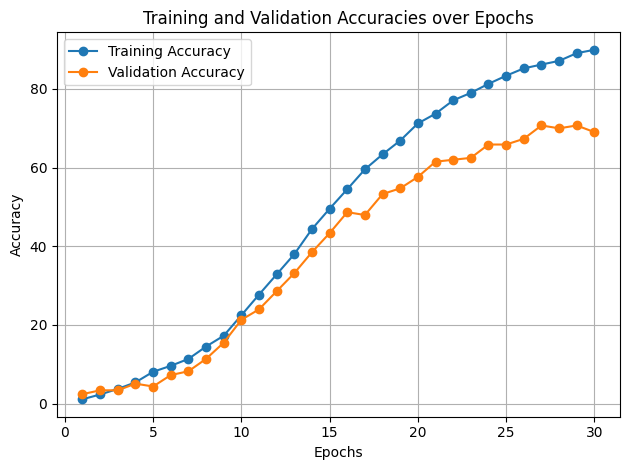

In [46]:
epochs_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(epochs_list, train_accs, marker='o', label='Training Accuracy')
plt.plot(epochs_list, val_accs, marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracies over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


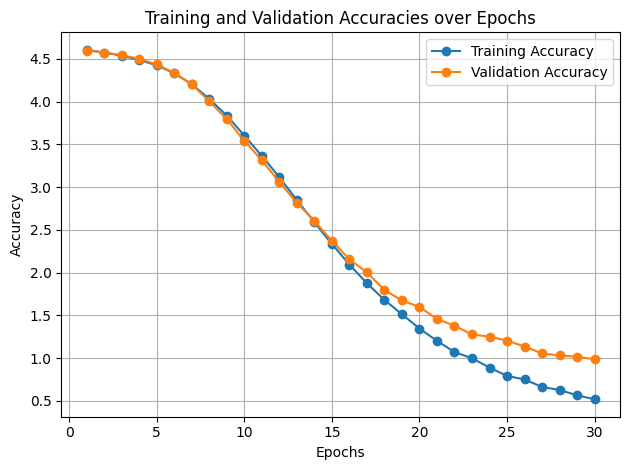

In [47]:
plt.plot(epochs_list, train_losses, marker='o', label='Training Accuracy')
plt.plot(epochs_list, val_losses, marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracies over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Generating test labels